# Project 2- Modeling Motion Through Water

## Purpose
The goal of this project was to create a model of the motion of a projectile underwater. Specifically, it investigated how differences in the starting velocity (and the angle of said velocity) affect the distance the projectile will travel.

## Theoretical Model
This project assumes the following:
- The diameter of the ball is 50mm
- The mass of the ball is 0.15kg
- The ball is a perfect sphere

### Initial Velocity

The goal was to start with just a launch angle and velocity for the ball.

So, that needs to be broken down into the x- and y-components of the velocity. For that, we can use trigonometry:

$$vx_0 = v_0 * cos(\theta)$$

and

$$vy_0 = v_0 * sin(\theta)$$

### Net Force
Now that we have the velocity split into two components, we need to calculate the forces acting on the ball. They include:
- Drag in the -x direction (a reactionary force against the force the ball exerts on the air/water in front of it)
- Drag in the -y direction (a reactionary force against the force the ball exerts on the air/water above it)
- Buoyancy (the upward pressure exerted on the object by the fluid)
- Gravity (pulling the object downwards)

#### A Brief Aside About Drag
We want to be able to handle motion of the object both in and out of the water. As a result, we need to account for the differing strengths of the force of drag in water and in air. So, the program has two values, rho_water and rho_air, to hold these respectively, and they're used depending on the state of the ball (whether it's in water or the air).

#### Calculating Drag
To get the force of drag acting on the object, we use the following equation:

$$F_d = \frac{1/2} * C_d * \rho * A $$

Where Cd is the drag coefficient (approximated to 0.5 for a perfect sphere), rho is the density of the fluid (water or air, in our case), and A is the cross-sectional area of the object. In this instance, the cross-sectional area of a sphere is just the area of a circle, so we can take pi times the radius squared:

$$ A_{circle} = \pi * r^2$$

#### Calculating Buoyancy
Buoyancy is a force resulting from the pressure exerted on the object as a result of the displacement of fluid. In other words, when the ball is in the water, it's pushing water out of it's space. This pressure increases as depth does, which means that the force on the bottom of the ball is greater than the force on the top, causing the buoyant force to be net upward. We calculate it with the following equation:

$$ F_b = \rho * g * V $$

Rho in this instance would be the rho value we have for water. Air can exert a buoyant force (which is how ballons float, for example) but for the object we're using, the force is going to be negligible. 

g corresponds to the acceleration due to gravity, which is -9.8 m/s^2. 
 
V represents the volume of the displaced fluid, which is the same as the volume of the object. Because we're using a sphere, this ends up being:

$$ V_{sphere} = \frac{4/3} * \pi * r^3 $$

#### Gravity:
This project is set on Earth, so gravity is calculated as follows:

$$ F_{grav} = m * g $$

Where, again, g is -9.8 m/s^2, and m is the mass of the object.


### ODEs

The odes being used to get the positions at each time step are as follows:

$$\frac{dx}{dt} = v_x \qquad \frac{dy}{dt} = v_y \qquad$$

$$\frac{d v_x}{dt} = \frac{F_{net,x}}{m} \qquad \frac{d v_y}{dt} = \frac{F_{net,y}}{m} \qquad$$




## Code
The launch angle (denoted as theta) and initial (launch) speed (denoted as v0) can both be adjusted to yield different results

The ball is assumed to start at position (0,0), and the ground is assued to be at y-level 0, so only points above that instance are graphed.

The variable w_line is used to control the water line - in other words, where the water ends and the air begins. 

This first test will simply be an oject underwater, with a starting velocity of 70 m/s at a 45 degree angle.

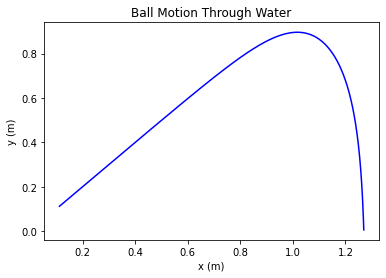

In [2]:
import ode
import numpy as np
import matplotlib.pyplot as plt


###These values can be adjusted to yield different results
theta = 45 #launch angle, in degrees
v0 = 70 #lanuch speed, in m/s

g = 9.8 #N/kg
rho_air = 1.2 #kg/m^3
rho_water = 1e3 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 50e-3/2 #50 mm diameter
A = np.pi*r**2 #cross-sectional area
Cd = 0.5 #actually depends on speed
m = 0.15 #kg
V = 4/3 * np.pi * r **3 #volume of the sphere
draga = 1/2*Cd*rho_air*A
dragw = 1/2*Cd*rho_water*A
buoy = rho_water*g*V

thetarad = theta*np.pi/180 #convert deg to rad

x0 = 0
y0 = 0
vx0 = v0*np.cos(thetarad)
vy0 = v0*np.sin(thetarad)

data = np.array([x0,y0,vx0,vy0]) #initialize dep vars

t = 0
h = 0.01
Nsteps = 10000

traj = np.zeros((Nsteps,3)) #trajectory
traj[0,:] = np.array([t,x0,y0]) 

w_line = False #we're below the water line

def drag(d, tn): #return value of derivatives at this t
    x = d[0]
    y = d[1]
    vx = d[2]
    vy = d[3]
    
    if w_line:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-draga*speed*vx/m) #dvx/dt
        deriv[3] = ((-draga*speed*vy - m*g)/m) #dvy/dt
        
    else:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-dragw*speed*vx/m) #dvx/dt
        deriv[3] = (-dragw*speed*vy + 2*buoy - m*g)/m #dvy/dt


    return deriv
    
for n in range(0,Nsteps-1):
    
    #update data
    data = ode.rk4(drag,data,t,h) #4 arguments
    
    #update time
    t = t+h
    
    #store trajectory data
    traj[n+1,:] = np.array([t,data[0],data[1]])

traj2 = traj[traj[:,2]>0]
    
plt.figure()
plt.title("Ball Motion Through Water")
plt.plot(traj2[:,1], traj2[:,2], 'b-')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

As we can see, the ball starts off moving fairly rapidly upward, but the force of drag quickly slows it, and it drops fairly suddenly after reaching 1m in the x direction.

Now, we'll run the same test with the same initial conditions, but entirely above the water:

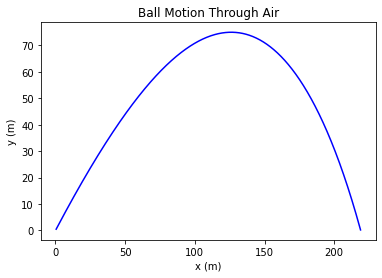

In [3]:
theta = 45 #launch angle, in degrees
v0 = 70 #lanuch speed, in m/s

g = 9.8 #N/kg
rho_air = 1.2 #kg/m^3
rho_water = 1e3 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 50e-3/2 #50 mm diameter
A = np.pi*r**2 #cross-sectional area
Cd = 0.5 #actually depends on speed
m = 0.15 #kg
V = 4/3 * np.pi * r **3 #volume of the sphere
draga = 1/2*Cd*rho_air*A
dragw = 1/2*Cd*rho_water*A
buoy = rho_water*g*V

thetarad = theta*np.pi/180 #convert deg to rad

x0 = 0
y0 = 0
vx0 = v0*np.cos(thetarad)
vy0 = v0*np.sin(thetarad)

data = np.array([x0,y0,vx0,vy0]) #initialize dep vars

t = 0
h = 0.01
Nsteps = 10000

traj = np.zeros((Nsteps,3)) #trajectory
traj[0,:] = np.array([t,x0,y0]) 

w_line = True #we are now above the water

def drag(d, tn): #return value of derivatives at this t
    x = d[0]
    y = d[1]
    vx = d[2]
    vy = d[3]
    
    if w_line:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-draga*speed*vx/m) #dvx/dt
        deriv[3] = ((-draga*speed*vy - m*g)/m) #dvy/dt
        
    else:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-dragw*speed*vx/m) #dvx/dt
        deriv[3] = (-dragw*speed*vy + 2*buoy - m*g)/m #dvy/dt


    return deriv

for n in range(0,Nsteps-1):
    
    #update data
    data = ode.rk4(drag,data,t,h) #4 arguments
    
    #update time
    t = t+h
    
    #store trajectory data
    traj[n+1,:] = np.array([t,data[0],data[1]])

traj2 = traj[traj[:,2]>0]
    
plt.figure()
plt.title("Ball Motion Through Air")
plt.plot(traj2[:,1], traj2[:,2], 'b-')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

As you would expect, the ball travels a significantly farther distance both in the +x and +y directions. This is as expected, however, as the force of drag in water is more than 100 times as strong as the force of drag in air. This gives us some hints that our results may indeed be valid.

Another interesting result that we can see is that in water, the "drop off" is fairly sudden, but the curve we get for the air is much more parabolic in nature. This is due to the force of drag being much greater in water - in other words, the x-velocity is slowing much faster in the first curve, which causes it to travel not quite as far in the x-direction.

Now, let's run the same simulation, but set the water level at 0.5 m. In other words, once the y position of the ball is above 0.5, it will have the drag force of air acting on it instead of the drag force of water (and it will lose the effects of buoyancy):

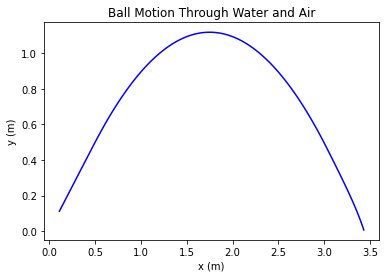

In [4]:
theta = 45 #launch angle, in degrees
v0 = 70 #lanuch speed, in m/s

g = 9.8 #N/kg
rho_air = 1.2 #kg/m^3
rho_water = 1e3 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 50e-3/2 #50 mm diameter
A = np.pi*r**2 #cross-sectional area
Cd = 0.5 #actually depends on speed
m = 0.15 #kg
V = 4/3 * np.pi * r **3 #volume of the sphere
draga = 1/2*Cd*rho_air*A
dragw = 1/2*Cd*rho_water*A
buoy = rho_water*g*V

thetarad = theta*np.pi/180 #convert deg to rad

x0 = 0
y0 = 0
vx0 = v0*np.cos(thetarad)
vy0 = v0*np.sin(thetarad)

data = np.array([x0,y0,vx0,vy0]) #initialize dep vars

t = 0
h = 0.01
Nsteps = 10000

traj = np.zeros((Nsteps,3)) #trajectory
traj[0,:] = np.array([t,x0,y0]) 

w_line = False #start below the water

def drag(d, tn): #return value of derivatives at this t
    x = d[0]
    y = d[1]
    vx = d[2]
    vy = d[3]
    
    if w_line:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-draga*speed*vx/m) #dvx/dt
        deriv[3] = ((-draga*speed*vy - m*g)/m) #dvy/dt
        
    else:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-dragw*speed*vx/m) #dvx/dt
        deriv[3] = (-dragw*speed*vy + 2*buoy - m*g)/m #dvy/dt


    return deriv

for n in range(0,Nsteps-1):
    
    #update data
    data = ode.rk4(drag,data,t,h) #4 arguments
    
    #update time
    t = t+h
    
    #store trajectory data
    traj[n+1,:] = np.array([t,data[0],data[1]])
    if data[1] > 0.5:
        w_line = True
    else: 
        w_line = False

traj2 = traj[traj[:,2]>0]
    
plt.figure()
plt.title("Ball Motion Through Water and Air")
plt.plot(traj2[:,1], traj2[:,2], 'b-')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

As we can see, it travels farther than it would in water by itself, but not nearly as far as it would through just air. This, again, is as expected. 

We can also test different launch angles and velocities to see how things change. For example, the next version runs on the previous one, with a higher angle (60 degrees):

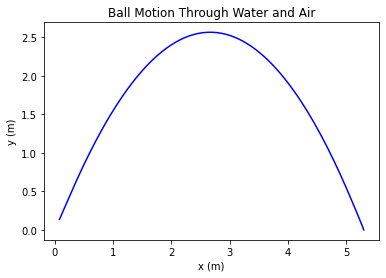

In [5]:
theta = 60 #launch angle, in degrees
v0 = 70 #lanuch speed, in m/s

g = 9.8 #N/kg
rho_air = 1.2 #kg/m^3
rho_water = 1e3 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 50e-3/2 #50 mm diameter
A = np.pi*r**2 #cross-sectional area
Cd = 0.5 #actually depends on speed
m = 0.15 #kg
V = 4/3 * np.pi * r **3 #volume of the sphere
draga = 1/2*Cd*rho_air*A
dragw = 1/2*Cd*rho_water*A
buoy = rho_water*g*V

thetarad = theta*np.pi/180 #convert deg to rad

x0 = 0
y0 = 0
vx0 = v0*np.cos(thetarad)
vy0 = v0*np.sin(thetarad)

data = np.array([x0,y0,vx0,vy0]) #initialize dep vars

t = 0
h = 0.01
Nsteps = 10000

traj = np.zeros((Nsteps,3)) #trajectory
traj[0,:] = np.array([t,x0,y0]) 

w_line = False #start below the water

def drag(d, tn): #return value of derivatives at this t
    x = d[0]
    y = d[1]
    vx = d[2]
    vy = d[3]
    
    if w_line:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-draga*speed*vx/m) #dvx/dt
        deriv[3] = ((-draga*speed*vy - m*g)/m) #dvy/dt
        
    else:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-dragw*speed*vx/m) #dvx/dt
        deriv[3] = (-dragw*speed*vy + 2*buoy - m*g)/m #dvy/dt


    return deriv

for n in range(0,Nsteps-1):
    
    #update data
    data = ode.rk4(drag,data,t,h) #4 arguments
    
    #update time
    t = t+h
    
    #store trajectory data
    traj[n+1,:] = np.array([t,data[0],data[1]])
    if data[1] > 0.5:
        w_line = True
    else: 
        w_line = False

traj2 = traj[traj[:,2]>0]
    
plt.figure()
plt.title("Ball Motion Through Water and Air")
plt.plot(traj2[:,1], traj2[:,2], 'b-')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

As we can see, the ball travels both farther and higher than it did last time - covering almost double the distance in both directions. This is likely because with the higher starting angle, the ball exits the water at an earlier time step. While it's in the water, it has a higher force of drag acting on it and slowing it's velocity. Therefore, if the ball exits the water quicker, it retains more of its initial velocity.

Next, we'll change the speed, adjusting it to 75, but retaining the 45 degree launch angle:

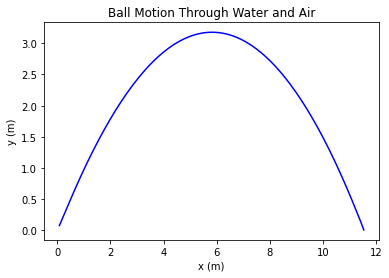

In [11]:
theta = 45 #launch angle, in degrees
v0 = 75 #lanuch speed, in m/s

g = 9.8 #N/kg
rho_air = 1.2 #kg/m^3
rho_water = 1e3 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 50e-3/2 #50 mm diameter
A = np.pi*r**2 #cross-sectional area
Cd = 0.5 #actually depends on speed
m = 0.15 #kg
V = 4/3 * np.pi * r **3 #volume of the sphere
draga = 1/2*Cd*rho_air*A
dragw = 1/2*Cd*rho_water*A
buoy = rho_water*g*V

thetarad = theta*np.pi/180 #convert deg to rad

x0 = 0
y0 = 0
vx0 = v0*np.cos(thetarad)
vy0 = v0*np.sin(thetarad)

data = np.array([x0,y0,vx0,vy0]) #initialize dep vars

t = 0
h = 0.01
Nsteps = 10000

traj = np.zeros((Nsteps,3)) #trajectory
traj[0,:] = np.array([t,x0,y0]) 

w_line = False #start below the water

def drag(d, tn): #return value of derivatives at this t
    x = d[0]
    y = d[1]
    vx = d[2]
    vy = d[3]
    
    if w_line:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-draga*speed*vx/m) #dvx/dt
        deriv[3] = ((-draga*speed*vy - m*g)/m) #dvy/dt
        
    else:
        deriv = np.zeros(4) #contains derivatives of data
        deriv[0] = vx #dx/dt
        deriv[1] = vy #dy/dt
        speed = np.sqrt(vx**2+vy**2)
        deriv[2] = (-dragw*speed*vx/m) #dvx/dt
        deriv[3] = (-dragw*speed*vy + 2*buoy - m*g)/m #dvy/dt


    return deriv

for n in range(0,Nsteps-1):
    
    #update data
    data = ode.rk4(drag,data,t,h) #4 arguments
    
    #update time
    t = t+h
    
    #store trajectory data
    traj[n+1,:] = np.array([t,data[0],data[1]])
    if data[1] > 0.5:
        w_line = True
    else: 
        w_line = False

traj2 = traj[traj[:,2]>0]
    
plt.figure()
plt.title("Ball Motion Through Water and Air")
plt.plot(traj2[:,1], traj2[:,2], 'b-')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

This shows an even greater increase in distance - with the higher initial velocity, it makes sense that the ball would travel farther in both the x- and y-directions.  

## Conclusions
The simulation performed mostly as expected - the drag in water significantly reduces the velocity at a much greater rate than the ball experiences in the air. As a result, the earlier and faster the ball leaves the water, the more distance it will end up covering.  